In [249]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model
from sklearn.ensemble import GradientBoostingClassifier
## for explainer
from lime import lime_tabular
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [250]:
df_data = pd.read_pickle('fullCleanedData.pkl')

In [251]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [252]:
#remove scroll
df_data_without_scroll = df_data.loc[df_data["type"] !="scroll"]
df_data_without_scroll.head()

,elementId,timeStamp,type,siteName,clientX,clientY,session,height,width,browser,key,sitename,real_date
31206,12,0.0,514,TestEinfach,614.857006,614.857006,f8b87dd1-ee10-f939-8561-a8622504f872,635.0,375,NaN,Backspace,NaN,4.783890
26125,11,424832.5,510,TestSchwer,194.000000,194.000000,41f22727-0a74-d41b-d6c2-29936806a037,358.0,360,NaN,NaN,NaN,4.755718
8443,11,219164.7,514,TestEinfach,614.857006,614.857006,67cc623a-295c-f6e0-67bc-c6f312d942ce,1304.0,2117,NaN,Backspace,NaN,1.701700
14138,17,94014.0,512,TestSchwer,614.857006,614.857006,36e6c57d-0872-8c05-e643-b2491fe5c9cd,1217.0,1440,Chrome,NaN,TestSchwer,1.937664
10550,12,976685.0,511,TestSchwer,418.000000,418.000000,90ab4d9b-1f2b-12d8-0607-da60d299f472,866.0,1439,NaN,NaN,NaN,1.714962


In [253]:
df_einfach = pd.DataFrame(df_data_without_scroll.loc[df_data_without_scroll['siteName']=='TestEinfach'])
df_schwer = pd.DataFrame(df_data_without_scroll.loc[df_data_without_scroll['siteName']=='TestSchwer'])

In [254]:
df_einfach.head()

,elementId,timeStamp,type,siteName,clientX,clientY,session,height,width,browser,key,sitename,real_date
31206,12,0.0,514,TestEinfach,614.857006,614.857006,f8b87dd1-ee10-f939-8561-a8622504f872,635.0,375,NaN,Backspace,NaN,4.783890
8443,11,219164.7,514,TestEinfach,614.857006,614.857006,67cc623a-295c-f6e0-67bc-c6f312d942ce,1304.0,2117,NaN,Backspace,NaN,1.701700
14701,11,96130.5,514,TestEinfach,614.857006,614.857006,d5c86034-0991-2594-ca59-fa08c4fb3112,1304.0,3440,NaN,Backspace,NaN,1.960783
9132,12,39193.6,514,TestEinfach,614.857006,614.857006,b0c22fd2-b15b-4344-eaa2-634377cb1ff9,1295.0,2171,NaN,Backspace,NaN,1.705816
7436,19,994045.5,514,TestEinfach,614.857006,614.857006,69e4a6b4-0c82-f9be-c9d2-ea959fb5ac90,962.0,1724,NaN,Backspace,NaN,1.050133


In [255]:
# new sessionId 
import random
from random import choice
import collections

array_of_ids_einfach = df_einfach['session'].value_counts().index.tolist()
array_of_ids_schwer = df_schwer['session'].value_counts().index.tolist()
numbers_schwer = []

random_numbers_ids_einfach = random.sample(range(101,1000), len(array_of_ids_einfach))
for i in range(len(random_numbers_ids_einfach)):
    random_numbers_ids_schwer = random.choice([i for i in range(101, 1000) if i not in random_numbers_ids_einfach])
    numbers_schwer.append(random_numbers_ids_schwer)

numbers = random_numbers_ids_einfach + numbers_schwer

df_einfach['session'] = df_einfach['session'].replace(array_of_ids_einfach, random_numbers_ids_einfach)
df_schwer['session'] = df_schwer['session'].replace(array_of_ids_schwer, numbers_schwer)

print([item for item, count in collections.Counter(numbers).items() if count > 1])

[425, 540, 930, 807]


In [256]:
df_data = pd.concat([df_einfach, df_schwer])

In [257]:
df_data['siteName'] = df_data['siteName'].replace('TestEinfach', 0)
df_data['siteName'] = df_data['siteName'].replace('TestSchwer', 1)

In [258]:
df_data = df_data.drop(['sitename', 'key', 'browser', 'elementId'], axis=1)

In [259]:
from sklearn.utils import shuffle
df_data = shuffle(df_data)

In [260]:
df_data.reset_index(inplace=True)

In [261]:
df_data.head()
# Das Ding ist, wir können nicht auf elementId predichten bzw. denen unterschiedliche Nummern geben, weil wir ja schon wissen ob ein Element auf der einen oder anderen Seite ist. Das heißt wir müssen alle elementIds entfernen 

,index,timeStamp,type,siteName,clientX,clientY,session,height,width,real_date
0,14909,142695.1,510,1,683.000000,683.000000,639,878.0,1920,2.003124
1,16091,96683.0,510,1,491.000000,491.000000,390,877.0,1627,2.112858
2,12237,335785.0,515,1,614.857006,614.857006,760,967.0,1291,1.728335
3,9760,97137.0,513,1,614.857006,614.857006,997,975.0,1920,1.710167
4,9915,265175.0,510,1,1226.000000,1226.000000,997,975.0,1920,1.712114


In [262]:
df_data.to_pickle('modelTrainingDataSet.pkl')

In [263]:
dataset = pd.read_pickle('modelTrainingDataSet.pkl')

In [264]:
siteName = 'siteName'

In [265]:
dataset = dataset.drop(['elementId'], axis=1)

KeyError: "['elementId'] not found in axis"

In [ ]:
dtf_train, dtf_test = model_selection.train_test_split(dataset,test_size=0.3)## print info
print("X_train shape:", dtf_train.drop("siteName",axis=1).shape, "| X_test shape:", dtf_test.drop("siteName",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["siteName"]),2), "| y_test mean:", round(np.mean(dtf_test["siteName"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("siteName",axis=1).columns.to_list())


X_train shape: (6217, 9) | X_test shape: (2665, 9)
y_train mean: 0.68 | y_test mean: 0.68
10 features: ['index', 'timeStamp', 'type', 'clientX', 'clientY', 'session', 'height', 'width', 'real_date']


In [ ]:
from numpy import array
type_array = dtf_train['type']
values = array(type_array)

In [ ]:
dummy = pd.get_dummies(dtf_train["type"], prefix="type",drop_first=True)
dtf_train= pd.concat([dtf_train, dummy], axis=1)
print( dtf_train.filter(like="type", axis=1).head())
columndtf = dtf_train.drop("type", axis=1)

      type  type_511  type_512  type_513  type_514  type_515
3121   511         1         0         0         0         0
6868   514         0         0         0         1         0
3832   510         0         0         0         0         0
216    512         0         1         0         0         0
6890   514         0         0         0         1         0


In [ ]:
#die features skalieren bessere Verteilung
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dtf_train.drop("siteName", axis=1))
dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop("siteName", axis=1).columns, index=dtf_train.index)
dtf_scaled["siteName"] = dtf_train["siteName"]
dtf_scaled.head()


,index,timeStamp,type,clientX,clientY,session,height,width,real_date,type_511,type_512,type_513,type_514,type_515,siteName
3121,0.351351,0.001158,0.2,0.493112,0.493112,0.650901,0.660920,0.363312,0.094016,1.0,0.0,0.0,0.0,0.0,1
6868,0.773311,0.123893,0.8,0.275467,0.275467,0.331081,0.097701,0.016883,0.460007,0.0,0.0,0.0,1.0,0.0,0
3832,0.431419,0.013095,0.0,0.265558,0.265558,0.650901,0.660920,0.363312,0.093990,0.0,0.0,0.0,0.0,0.0,1
216,0.024212,0.004652,0.4,0.275467,0.275467,0.862613,0.383780,0.506494,0.193710,0.0,1.0,0.0,0.0,0.0,1
6890,0.775788,0.029595,0.8,0.275467,0.275467,0.147523,0.650064,0.587987,0.165234,0.0,0.0,0.0,1.0,0.0,0


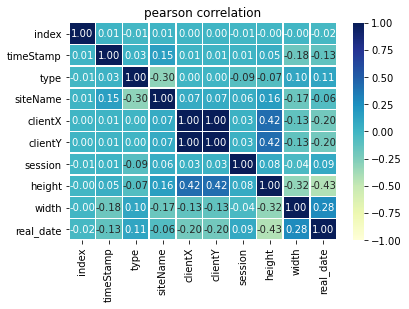

In [ ]:
#die helleren Stellen können interessant sein, da der Pearson Wert recht niedrig ist
corr_matrix = dataset.copy()
for col in corr_matrix.columns:    
    if corr_matrix[col].dtype == "O":         
        corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
        corr_matrix = corr_matrix.corr(method="pearson")
        sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
        plt.title("pearson correlation")

In [ ]:
X = dtf_train.drop("Y", axis=1).valuesy = dtf_train["Y"].valuesfeature_names = dtf_train.drop("Y", axis=1).columns.tolist()## Importancemodel = ensemble.RandomForestClassifier(n_estimators=100,                      criterion="entropy", random_state=0)model.fit(X,y)importances = model.feature_importances_## Put in a pandas dtfdtf_importances = pd.DataFrame({"IMPORTANCE":importances,             "VARIABLE":feature_names}).sort_values("IMPORTANCE",             ascending=False)dtf_importances['cumsum'] =              dtf_importances['IMPORTANCE'].cumsum(axis=0)dtf_importances = dtf_importances.set_index("VARIABLE")    ## Plotfig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)fig.suptitle("Features Importance", fontsize=20)ax[0].title.set_text('variables')    dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(                kind="barh", legend=False, ax=ax[0]).grid(axis="x")ax[0].set(ylabel="")ax[1].title.set_text('cumulative')dtf_importances[["cumsum"]].plot(kind="line", linewidth=4,                                  legend=False, ax=ax[1])ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)),           xticklabels=dtf_importances.index)plt.xticks(rotation=70)plt.grid(axis='both')plt.show()


### Random Forest

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = dataset[['type', 'timeStamp','height', 'width']]
Y = dataset['siteName']

X = StandardScaler().fit_transform(X)

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.30, 
                                                    random_state = 42)

NameError: name 'dataset' is not defined

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_Train,Y_Train)

y_pred=clf.predict(X_Test)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_Test, y_pred))

Accuracy: 0.9369606003752345


In [ ]:
# das ist ja dann eigentlich nur ein Event, das wollen wir ja nicht predicten sondern eine Session
clf.predict([[510, 0, 920, 200]])

array([1])

### SVM

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_Train, Y_Train)

#Predict the response for test dataset
y_pred = clf.predict(X_Test)

In [ ]:
from sklearn.svm import LinearSVC

clf2 = LinearSVC(C=1.0, loss='hinge', class_weight='balanced')

clf2.fit(X_Train, Y_Train)

print('Done')

NameError: name 'X_Train' is not defined

In [ ]:
from sklearn.metrics import accuracy_score

y_test_pred = clf.predict(X_Test)
y_train_pred = clf.predict(X_Train)

print(f'Classifier: {clf.__class__}\n')

print('Accuracy Summary')
print('================')

print(f'Test:    {accuracy_score(Y_Test, y_test_pred)*100:6.2f}%')
print(f'Train:   {accuracy_score(Y_Train, y_train_pred)*100:6.2f}%')

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_Test, y_pred))

Accuracy: 0.7215759849906191


In [ ]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(Y_Test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(Y_Test, y_pred))

Precision: 0.77947932618683
Recall: 0.8312465977136636


# Sessions

In [392]:
df_sessions = pd.read_pickle('SortedBySessions2.pkl')

In [393]:
df_sessions.head()

,session,count_mouseover,count_mouseout,count_click,count_blur,count_focus,count_keydown,count_all,duration,height,width,siteName,clientX,clientY
0,515,32,32,14,26,28,27,159,136.831,1312.0,1479.0,1,359.0,320.0
1,519,1,0,0,1,1,0,3,33.249,669.0,390.0,1,266.0,282.0
2,524,42,42,8,17,16,5,130,230.175,878.0,1920.0,1,674.0,468.0
3,528,4,3,0,6,6,0,19,20.563,1217.0,1440.0,0,397.0,469.0
4,554,6,6,0,6,6,0,24,17.076,715.0,414.0,0,346.0,301.0


In [394]:
X_session = df_sessions[['count_all', 'duration']]
Y_session = df_sessions['siteName']

X_session = StandardScaler().fit_transform(X_session)

X_session_Train, X_session_Test, Y_session_Train, Y_session_Test = train_test_split(X_session, Y_session, test_size = 0.30, 
                                                    random_state = 101)

#### Random Forest Session

Accuracy: 0.8974358974358975

With Hyperparameter: Accuracy: 0.9230769230769231


In [395]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# evaluate random forest algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

#Create a Gaussian Classifier
forest_model=RandomForestClassifier(n_estimators=1000, random_state=101)

#Train the model using the training sets y_pred=clf.predict(X_test)
forest_model.fit(X_session_Train,Y_session_Train)

y_session_pred=forest_model.predict(X_session_Test)

In [396]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef
print('Accuracy: %.3f' % accuracy_score(Y_session_Test, y_session_pred))
print('Precision: %.3f' % precision_score(Y_session_Test, y_session_pred))
print('Recall: %.3f' % recall_score(Y_session_Test, y_session_pred))
print('Confusion Matrix:', confusion_matrix(Y_session_Test, y_session_pred))
print('AUC Score: %.3f' % metrics.roc_auc_score(Y_session_Test, y_session_pred))
print('MCC Score: %.3f' % matthews_corrcoef(Y_session_Test, y_session_pred))
print('F1 Score: %.3f' % f1_score(Y_session_Test, y_session_pred))


Accuracy: 0.972
Precision: 0.955
Recall: 1.000
Confusion Matrix: [[14  1]
 [ 0 21]]
AUC Score: 0.967
MCC Score: 0.944
F1 Score: 0.977


In [363]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)

knn_model.fit(X_session_Train, Y_session_Train)

y_knn_pred = knn_model.predict(X_session_Test) # 0:Overcast, 2:Mild

In [364]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef
print('Accuracy: %.3f' % accuracy_score(Y_session_Test, y_knn_pred))
print('Precision: %.3f' % precision_score(Y_session_Test, y_knn_pred))
print('Recall: %.3f' % recall_score(Y_session_Test, y_knn_pred))
print('Confusion Matrix:', confusion_matrix(Y_session_Test, y_knn_pred))
print('AUC Score: %.3f' % metrics.roc_auc_score(Y_session_Test, y_knn_pred))
print('MCC Score: %.3f' % matthews_corrcoef(Y_session_Test, y_knn_pred))
print('F1 Score: %.3f' % f1_score(Y_session_Test, y_knn_pred))

Accuracy: 0.750
Precision: 0.875
Recall: 0.667
Confusion Matrix: [[13  2]
 [ 7 14]]
AUC Score: 0.767
MCC Score: 0.529
F1 Score: 0.757


/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


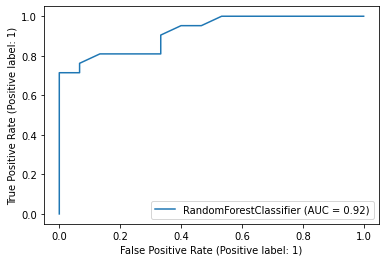

In [325]:
metrics.plot_roc_curve(forest_model, X_session_Test, Y_session_Test)
plt.show()

#### Improve Random Forest with Hyperparameter

In [ ]:
rfc_model = RandomForestClassifier()

parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None]
    
}

In [ ]:
from sklearn.model_selection import GridSearchCV
cv_grid = GridSearchCV(rfc_model,parameters,cv=5)
cv_grid.fit(X_session, Y_session.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 8, 16, 32, None],
                         'n_estimators': [5, 10, 50, 100, 250]})

In [ ]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [ ]:
display(cv_grid)

Best parameters are: {'max_depth': 8, 'n_estimators': 250}


0.933 + or -0.033 for the {'max_depth': 2, 'n_estimators': 5}
0.908 + or -0.031 for the {'max_depth': 2, 'n_estimators': 10}
0.933 + or -0.02 for the {'max_depth': 2, 'n_estimators': 50}
0.908 + or -0.017 for the {'max_depth': 2, 'n_estimators': 100}
0.908 + or -0.017 for the {'max_depth': 2, 'n_estimators': 250}
0.917 + or -0.046 for the {'max_depth': 4, 'n_estimators': 5}
0.925 + or -0.017 for the {'max_depth': 4, 'n_estimators': 10}
0.942 + or -0.02 for the {'max_depth': 4, 'n_estimators': 50}
0.942 + or -0.02 for the {'max_depth': 4, 'n_estimators': 100}
0.95 + or -0.017 for the {'max_depth': 4, 'n_estimators': 250}
0.925 + or -0.076 for the {'max_depth': 8, 'n_estimators': 5}
0.958 + or -0.026 for the {'max_depth': 8, 'n_estimators': 10}
0.958 + or -0.026 for the {'max_depth': 8, 'n_estimators': 50}
0.95 + or -0.017 for the {'max_depth': 8, 'n_estimators': 100}
0.967 + or -0.017 for the {'max_depth': 8, 'n_estimators': 2

#### KNN

In [326]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)

knn_model.fit(X_session_Train, Y_session_Train)

y_knn_pred = knn_model.predict(X_session_Test) # 0:Overcast, 2:Mild


In [327]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef
print('Accuracy: %.3f' % accuracy_score(Y_session_Test, y_knn_pred))
print('Precision: %.3f' % precision_score(Y_session_Test, y_knn_pred))
print('Recall: %.3f' % recall_score(Y_session_Test, y_knn_pred))
print('Confusion Matrix:', confusion_matrix(Y_session_Test, y_knn_pred))
print('AUC Score: %.3f' % metrics.roc_auc_score(Y_session_Test, y_knn_pred))
print('MCC Score: %.3f' % matthews_corrcoef(Y_session_Test, y_knn_pred))
print('F1 Score: %.3f' % f1_score(Y_session_Test, y_knn_pred))

Accuracy: 0.778
Precision: 0.810
Recall: 0.810
Confusion Matrix: [[11  4]
 [ 4 17]]
AUC Score: 0.771
MCC Score: 0.543
F1 Score: 0.810


Robust Scaling to improve KNN --> Accuracy: 0.8717948717948718

MinMax Scaling to improve KNN --> Accuracy: 0.8461538461538461

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_session_robust = df_sessions[['count_mouseover', 'count_mouseout','count_click','count_blur','count_keydown','count_focus','duration']]
Y_session_robust = df_sessions['siteName']

X_session_robust = scaler.fit_transform(X_session_robust)

X_session_robust_Train, X_session_robust_Test, Y_session_robust_Train, Y_session_robust_Test = train_test_split(X_session_robust, Y_session_robust, test_size = 0.30, random_state = 101)

#Create KNN Object
knn_robust = KNeighborsClassifier()

knn_robust.fit(X_session_robust_Train, Y_session_robust_Train)

y_knn_pred_robust = knn_robust.predict(X_session_robust_Test)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef
print('Accuracy: %.3f' % accuracy_score(Y_session_Test, y_knn_pred_robust))
print('Precision: %.3f' % precision_score(Y_session_Test, y_knn_pred_robust))
print('Recall: %.3f' % recall_score(Y_session_Test, y_knn_pred_robust))
print('Confusion Matrix:', confusion_matrix(Y_session_Test, y_knn_pred_robust))
print('AUC Score: %.3f' % metrics.roc_auc_score(Y_session_Test, y_knn_pred_robust))
print('MCC Score: %.3f' % matthews_corrcoef(Y_session_Test, y_knn_pred_robust))
print('F1 Score: %.3f' % f1_score(Y_session_Test, y_knn_pred_robust))

Accuracy: 0.972
Precision: 1.000
Recall: 0.952
Confusion Matrix: [[15  0]
 [ 1 20]]
AUC Score: 0.976
MCC Score: 0.945
F1 Score: 0.976


Use Hyperparameter

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

hyper_model = GridSearchCV(knn_model, hyperparameters, cv=10)
best_model = hyper_model.fit(X_session_Train,Y_session_Train)

print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])


Best leaf_size: 1
Best p: 2
Best n_neighbors: 5


In [ ]:
y_hyper_pred = best_model.predict(X_session_Test)
print("Accuracy:",metrics.accuracy_score(Y_session_Test, y_hyper_pred))

Accuracy: 1.0


#### Linear Discriminat Analysis

In [ ]:
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_session_Train, Y_session_Train)

LinearDiscriminantAnalysis()

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(lda_model, X_session, Y_session, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))   


0.8444444444444443


#### Logistic Regression

In [313]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg_model = LogisticRegression(random_state=16)

# fit the model with data
logreg_model.fit(X_session_Train, Y_session_Train)

y_logreg_pred = logreg_model.predict(X_session_Test)

In [314]:
print('Accuracy: %.3f' % accuracy_score(Y_session_Test, y_logreg_pred))
print('Precision: %.3f' % precision_score(Y_session_Test, y_logreg_pred))
print('Recall: %.3f' % recall_score(Y_session_Test, y_logreg_pred))
print('Confusion Matrix:', confusion_matrix(Y_session_Test, y_logreg_pred))
print('AUC Score: %.3f' % metrics.roc_auc_score(Y_session_Test, y_logreg_pred))
print('MCC Score: %.3f' % matthews_corrcoef(Y_session_Test, y_logreg_pred))
print('F1 Score: %.3f' % f1_score(Y_session_Test, y_logreg_pred))

Accuracy: 0.861
Precision: 1.000
Recall: 0.762
Confusion Matrix: [[15  0]
 [ 5 16]]
AUC Score: 0.881
MCC Score: 0.756
F1 Score: 0.865


#### Naive Bayes

In [ ]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb_model = GaussianNB()

#Train the model using the training sets
gnb_model.fit(X_session_Train, Y_session_Train)

#Predict the response for test dataset
y_gnb_pred = gnb_model.predict(X_session_Test)

In [ ]:
print('Accuracy: %.3f' % accuracy_score(Y_session_Test, y_gnb_pred))
print('Precision: %.3f' % precision_score(Y_session_Test, y_gnb_pred))
print('Recall: %.3f' % recall_score(Y_session_Test, y_gnb_pred))
print('Confusion Matrix:', confusion_matrix(Y_session_Test, y_gnb_pred))
print('AUC Score: %.3f' % metrics.roc_auc_score(Y_session_Test, y_gnb_pred))
print('MCC Score: %.3f' % matthews_corrcoef(Y_session_Test, y_gnb_pred))
print('F1 Score: %.3f' % f1_score(Y_session_Test, y_gnb_pred))

Accuracy: 0.861
Precision: 0.944
Recall: 0.810
Confusion Matrix: [[14  1]
 [ 4 17]]
AUC Score: 0.871
MCC Score: 0.732
F1 Score: 0.872


#### SVM

In [315]:
from sklearn import svm
#Create a svm Classifier
svm_model = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
svm_model.fit(X_session_Train, Y_session_Train)

#Predict the response for test dataset
y_svm_pred = svm_model.predict(X_session_Test)

In [316]:
print('Accuracy: %.3f' % accuracy_score(Y_session_Test, y_svm_pred))
print('Precision: %.3f' % precision_score(Y_session_Test, y_svm_pred))
print('Recall: %.3f' % recall_score(Y_session_Test, y_svm_pred))
print('Confusion Matrix:', confusion_matrix(Y_session_Test, y_svm_pred))
print('AUC Score: %.3f' % metrics.roc_auc_score(Y_session_Test, y_svm_pred))
print('MCC Score: %.3f' % matthews_corrcoef(Y_session_Test, y_svm_pred))
print('F1 Score: %.3f' % f1_score(Y_session_Test, y_svm_pred))

Accuracy: 0.861
Precision: 1.000
Recall: 0.762
Confusion Matrix: [[15  0]
 [ 5 16]]
AUC Score: 0.881
MCC Score: 0.756
F1 Score: 0.865


#### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_booster_model = GradientBoostingClassifier(learning_rate=0.1)
gradient_booster_model.fit(X_session_Train,Y_session_Train)

y_gradient_pred = gradient_booster_model.predict(X_session_Test)


In [ ]:
print('Accuracy: %.3f' % accuracy_score(Y_session_Test, y_gradient_pred))
print('Precision: %.3f' % precision_score(Y_session_Test, y_gradient_pred))
print('Recall: %.3f' % recall_score(Y_session_Test, y_gradient_pred))
print('Confusion Matrix:', confusion_matrix(Y_session_Test, y_gradient_pred))
print('AUC Score: %.3f' % metrics.roc_auc_score(Y_session_Test, y_gradient_pred))
print('MCC Score: %.3f' % matthews_corrcoef(Y_session_Test, y_gradient_pred))
print('F1 Score: %.3f' % f1_score(Y_session_Test, y_gradient_pred))

Accuracy: 0.944
Precision: 0.952
Recall: 0.952
Confusion Matrix: [[14  1]
 [ 1 20]]
AUC Score: 0.943
MCC Score: 0.886
F1 Score: 0.952


#### ANN / Multi-Layer-Perceptron
Batch-Size: 32 loss: 0.6364 - accuracy: 0.7333

Batch-Size: 16 loss: 0.5102 - accuracy: 0.8444

Batch-Size: 8  loss: 0.3590 - accuracy: 0.8556

Batch-Size: 32 and epochs: 100 loss: 0.6783 - accuracy: 0.7333


In [317]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
import tensorflow as tf

In [318]:
ann_model = tf.keras.models.Sequential()
ann_model.add(tf.keras.layers.Dense(units=4,activation="relu"))
ann_model.add(tf.keras.layers.Dense(units=4,activation="relu"))
ann_model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
ann_model.compile(optimizer="adam",loss="mean_squared_error",metrics=['accuracy'])
ann_model.fit(X_session_Train,Y_session_Train,batch_size=32,epochs = 50)

y_ann_pred=ann_model.predict(X_session_Test)

Epoch 1/50
3/3 [==============================] - 1s 3ms/step - loss: 0.2301 - accuracy: 0.8333
Epoch 2/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2279 - accuracy: 0.8333
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2257 - accuracy: 0.8571
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2238 - accuracy: 0.8929
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2219 - accuracy: 0.8929
Epoch 6/50
3/3 [==============================] - 0s 3ms/step - loss: 0.2203 - accuracy: 0.8929
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2187 - accuracy: 0.8810
Epoch 8/50
3/3 [==============================] - 0s 4ms/step - loss: 0.2173 - accuracy: 0.8810
Epoch 9/50
3/3 [==============================] - 0s 3ms/step - loss: 0.2159 - accuracy: 0.8810
Epoch 10/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2144 - accuracy: 0.8810
Epoch 11/50
3/3 [======================

# Sessions only mousedynamics

In [ ]:
df_mouse = pd.read_pickle('CleanedDataWithIds.pkl') 

In [ ]:
df_mouse = df_mouse.drop(['date', 'elementId', 'height', 'width' ], axis=1)
df_mouse.head()

,timeStamp,type,siteName,clientX,clientY,session
339,824.3,mouseover,0,673.000000,363.000000,243
340,858.3,mouseout,0,772.000000,333.000000,243
341,2005.3,mouseover,0,796.000000,266.000000,243
342,2296.5,focus,0,526.105402,333.262187,243
343,2875.3,mouseover,0,995.000000,264.000000,243


In [ ]:
df_mouseover = df_mouse.loc[df_mouse['type']=='mouseover']
df_mouseout = df_mouse.loc[df_mouse['type']=='mouseout']
df_mouse = pd.concat([df_mouseover, df_mouseout])

df_mouse['type'] = df_mouse['type'].replace('mouseover', 2)
df_mouse['type'] = df_mouse['type'].replace('mouseout', 3)

df_mouse.head()

,timeStamp,type,siteName,clientX,clientY,session
339,824.3,2,0,673.0,363.0,243
341,2005.3,2,0,796.0,266.0,243
343,2875.3,2,0,995.0,264.0,243
346,3258.3,2,0,880.0,267.0,243
359,18308.3,2,0,771.0,342.0,243


In [ ]:
X_mouse = df_mouse[['timeStamp', 'type','clientX', 'clientY']]
Y_mouse = df_mouse['siteName']

X_mouse = StandardScaler().fit_transform(X_mouse)

X_mouse_Train, X_mouse_Test, Y_mouse_Train, Y_mouse_Test = train_test_split(X_mouse, Y_mouse, test_size = 0.30, 
                                                    random_state = 101)

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
forest_model_mouse=RandomForestClassifier(n_estimators=250)

#Train the model using the training sets y_pred=clf.predict(X_test)
forest_model_mouse.fit(X_mouse_Train,Y_mouse_Train)

y_mouse_pred=forest_model_mouse.predict(X_mouse_Test)

In [ ]:
print('Accuracy: %.3f' % accuracy_score(Y_mouse_Test, y_mouse_pred))
print('Precision: %.3f' % precision_score(Y_mouse_Test, y_mouse_pred))
print('Recall: %.3f' % recall_score(Y_mouse_Test, y_mouse_pred))
print('Confusion Matrix:', confusion_matrix(Y_mouse_Test, y_mouse_pred))
print('AUC Score: %.3f' % metrics.roc_auc_score(Y_mouse_Test, y_mouse_pred))
print('MCC Score: %.3f' % matthews_corrcoef(Y_mouse_Test, y_mouse_pred))
print('F1 Score: %.3f' % f1_score(Y_mouse_Test, y_mouse_pred))

Accuracy: 0.925
Precision: 0.955
Recall: 0.954
Confusion Matrix: [[180  46]
 [ 47 971]]
AUC Score: 0.875
MCC Score: 0.749
F1 Score: 0.954


# CNN Sequential Data Model

In [876]:
df_seq = pd.read_pickle('CleanedDataWithIds.pkl') 
df_seq['date'] = df_seq['date'].astype('datetime64[ns]')

In [877]:
df_seq= df_seq.sort_values(by=['date', 'session'], ascending=[True, False])
df_seq.head()

,elementId,timeStamp,type,siteName,date,clientX,clientY,session,height,width
339,inputPet,824.3,mouseover,0,2022-10-17 13:35:24.171,673.000000,363.000000,243,944.0,1920.0
340,inputPet,858.3,mouseout,0,2022-10-17 13:35:24.205,772.000000,333.000000,243,944.0,1920.0
341,inputCountry,2005.3,mouseover,0,2022-10-17 13:35:25.361,796.000000,266.000000,243,944.0,1920.0
342,inputCountry,2296.5,focus,0,2022-10-17 13:35:25.652,526.105402,333.262187,243,944.0,1920.0
344,inputCountry,2875.3,mouseout,0,2022-10-17 13:35:26.229,995.000000,264.000000,243,944.0,1920.0


In [878]:
df_seq=df_seq.drop(['elementId', 'date'], axis=1)

In [879]:
df_seq.head()

,timeStamp,type,siteName,clientX,clientY,session,height,width
339,824.3,mouseover,0,673.000000,363.000000,243,944.0,1920.0
340,858.3,mouseout,0,772.000000,333.000000,243,944.0,1920.0
341,2005.3,mouseover,0,796.000000,266.000000,243,944.0,1920.0
342,2296.5,focus,0,526.105402,333.262187,243,944.0,1920.0
344,2875.3,mouseout,0,995.000000,264.000000,243,944.0,1920.0


In [881]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

df_encoded = df_seq.sort_values(by=['session', 'timeStamp'])

In [938]:
print(df_encoded)

       timeStamp  siteName      clientX      clientY  session  height   width  \
18052      587.0         1  1389.000000   465.000000      102  1279.0  3440.0   
18051      605.0         1  1385.000000   428.000000      102  1279.0  3440.0   
18054      704.0         1  1395.000000   316.000000      102  1279.0  3440.0   
18053      755.0         1  1416.000000   285.000000      102  1279.0  3440.0   
18055     1057.0         1  1416.000000   286.000000      102  1279.0  3440.0   
18056     1740.0         1   634.657848   460.161082      102  1279.0  3440.0   
18057     2243.0         1  1383.000000   281.000000      102  1279.0  3440.0   
18058    10708.0         1   634.657848   460.161082      102  1279.0  3440.0   
18059    10906.0         1   634.657848   460.161082      102  1279.0  3440.0   
18060    12122.0         1  1778.000000   448.000000      102  1279.0  3440.0   
18062    12189.0         1  1776.000000   468.000000      102  1279.0  3440.0   
18061    12273.0         1  

In [883]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

le = LabelEncoder()
df_encoded['siteName'] = le.fit_transform(df_encoded['siteName'])


In [884]:
df_encoded = pd.get_dummies(df_encoded, columns=['type'])

In [885]:
df_encoded.head()

,timeStamp,siteName,clientX,clientY,session,height,width,type_blur,type_click,type_focus,type_keydown,type_mouseout,type_mouseover
18052,587.0,1,1389.0,465.0,102,1279.0,3440.0,0,0,0,0,0,1
18051,605.0,1,1385.0,428.0,102,1279.0,3440.0,0,0,0,0,1,0
18054,704.0,1,1395.0,316.0,102,1279.0,3440.0,0,0,0,0,0,1
18053,755.0,1,1416.0,285.0,102,1279.0,3440.0,0,0,0,0,1,0
18055,1057.0,1,1416.0,286.0,102,1279.0,3440.0,0,0,0,0,0,1


In [892]:
X = df_encoded[['timeStamp']]
y = df_encoded['siteName']

In [937]:
from keras.optimizers import Adam
from sklearn.model_selection import KFold
# define and fit model
from keras import regularizers

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# reshape data for LSTM
X_train = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
# Add LSTM layer with kernel, recurrent and bias regularization
model.add(LSTM(64, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1], X_train.shape[2])))

# Add dropout layer
model.add(Dropout(0.5))

# Add output layer
model.add(Dense(1, activation='softmax'))

# Compile the model with Adam optimizer and categorical crossentropy loss function
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with increased number of epochs
model.fit(X_train, y_train, epochs=20, shuffle=False)

Epoch 1/20
222/222 [==============================] - 2s 2ms/step - loss: 0.6273 - accuracy: 0.8153
Epoch 2/20
222/222 [==============================] - 0s 2ms/step - loss: 0.3113 - accuracy: 0.8153
Epoch 3/20
222/222 [==============================] - 0s 2ms/step - loss: 0.1765 - accuracy: 0.8153
Epoch 4/20
222/222 [==============================] - 0s 2ms/step - loss: 0.0928 - accuracy: 0.8153
Epoch 5/20
222/222 [==============================] - 0s 2ms/step - loss: 0.0449 - accuracy: 0.8153
Epoch 6/20
222/222 [==============================] - 0s 2ms/step - loss: 0.0200 - accuracy: 0.8153
Epoch 7/20
222/222 [==============================] - 0s 2ms/step - loss: 0.0087 - accuracy: 0.8153
Epoch 8/20
222/222 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 0.8153
Epoch 9/20
222/222 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.8153
Epoch 10/20
222/222 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.8153

In [919]:
# evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Test loss: 0.010511194355785847
Test accuracy: 0.8214689493179321


### LSTM

In [ ]:
X_time_series = df_seq[['timeStamp', 'session']]
Y_time_series = df_seq['siteName']

X_time_series = StandardScaler().fit_transform(X_time_series)

X_time_Train, X_time_Test, Y_time_Train, Y_time_Test = train_test_split(X_time_series, Y_time_series, test_size = 0.30, 
                                                    random_state = 101)

In [ ]:
import tensorflow as tf

# Definition der Eingabeschicht
inputs = tf.keras.layers.Input(shape=(None,))  # Die Eingabeschicht erwartet sequentielle Daten mit variabler Länge

# Fügen Sie hier weitere Schichten hinzu, z.B. Embedding- oder Convolution-Schichten

# Definition der RNN-Schicht
rnn = tf.keras.layers.LSTM(64)(inputs)  # Verwenden Sie eine LSTM-Schicht mit 64 Neuronen

# Definition der Ausgabeschicht
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(rnn)  # Fügen Sie eine Dense-Schicht mit einer sigmoid-Aktivierungsfunktion hinzu

# Erstellen Sie das Modell mit den definierten Schichten
rnn_model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Kompilieren Sie das Modell mit einer Loss-Funktion und einem Optimierer
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Trainieren Sie das Modell anhand Ihrer Trainingsdaten
rnn_model.fit(X_time_Train, Y_time_Train, epochs=10)

# Verwenden Sie das Modell, um Vorhersagen anhand Ihrer Testdaten zu treffen
predictions = rnn_model.predict(X_time_Test)

ValueError: Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, None)